In [1]:
import torch
import numpy as np
from utils import prediction,normalization
import time
import matplotlib.pyplot as plt
# from thop import profile
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [2]:
device

device(type='cuda', index=0)

Load the model and data. Then set the inference size, each dimension of the inference size must be divisible by 16, supporting up to 640x640x640 cuboid inference on a 16GB GPU.

In [3]:
model = torch.jit.load('network/FaultNet_Gamma0.7.pt').to(device)
if device.type != 'cpu': model = model.half()
print('parameters_count:',count_parameters(model)/10**6,'MB')

parameters_count: 0.421597 MB


In [9]:
print(model)

RecursiveScriptModule(
  original_name=FaultNet
  (conv1): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Conv3d)
    (1): RecursiveScriptModule(original_name=BatchNorm3d)
    (2): RecursiveScriptModule(original_name=ReLU6)
  )
  (conv1_0): RecursiveScriptModule(
    original_name=BasicBlock
    (conv1): RecursiveScriptModule(original_name=Conv3d)
    (bn1): RecursiveScriptModule(original_name=BatchNorm3d)
    (relu): RecursiveScriptModule(original_name=ReLU6)
    (conv2): RecursiveScriptModule(original_name=Conv3d)
    (bn2): RecursiveScriptModule(original_name=BatchNorm3d)
  )
  (conv1_1): RecursiveScriptModule(original_name=Conv3d)
  (bn1_1): RecursiveScriptModule(original_name=BatchNorm3d)
  (relu): RecursiveScriptModule(original_name=ReLU6)
  (layer1): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(
      original_name=Bottleneck
      (conv1): RecursiveScriptModule(original_name=Conv3d)
      (b

Inference

In [4]:
data = np.load('data/F3.npy').transpose((2, 0, 1))
infer_size = data.shape 
print('infer size:',infer_size)
start = time.time()
result = prediction(model, data, device)
end = time.time()
print('1080Ti GPU infer time:',end-start,'s')

infer size: (128, 512, 384)
1080Ti GPU infer time: 14.036160230636597 s


In [12]:
data.shape,result.shape

((128, 512, 384), (128, 512, 384))

Show result

In [5]:
def get_result_img (geo_slice, result_slice):
    hm = plt.get_cmap('bone')(geo_slice)[:, :, :-1]
    geo_slice = plt.get_cmap('seismic')(geo_slice)[:, :, :-1]
    logits = np.clip((result_slice[:, :, None]), a_min=0, a_max=1)
    colormap = plt.get_cmap('jet')(logits[:, :, 0])[:, :, :-1]
    hm = np.where(logits > 0.5, colormap, hm)
    return geo_slice, hm

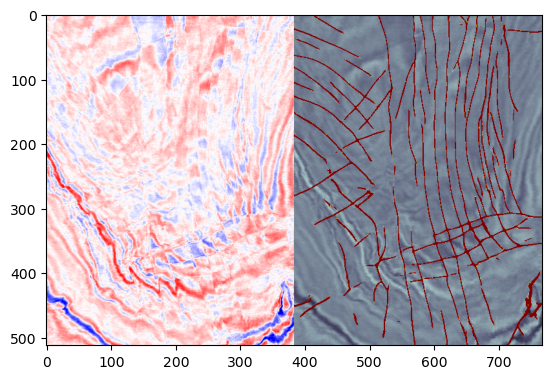

In [6]:
data = normalization(data)
tline_slice = data[105,:,:]
iline_slice = data[:,:,16]
xline_slice = data[:,20,:]
tline_result = result[105,:,:]
iline_result = result[:,:,16]
xline_result = result[:,20,:]
tline_slice,tline_result = get_result_img(tline_slice,tline_result)
iline_slice,iline_result = get_result_img(iline_slice,iline_result)
xline_slice,xline_result = get_result_img(xline_slice,xline_result)
tline = np.concatenate((tline_slice,tline_result),1)
iline = np.concatenate((iline_slice,iline_result),1)
xline = np.concatenate((xline_slice,xline_result),1)
plt.imshow(tline)

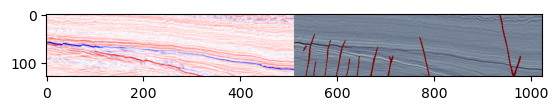

In [7]:
plt.imshow(iline)

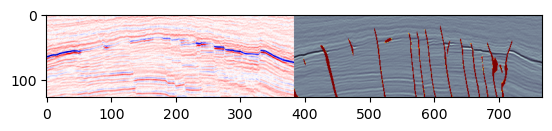

In [8]:
plt.imshow(xline)